In [1]:

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import time
import random
import scipy.stats as stats
from scipy.sparse import *
from mainSVT import *
from visualizingData import *
import pandas as pd
import os
import ast


In [2]:
# Load the data from the specified .npz file
file = np.load("..\\..\\data_manip\\provided_data\\FTICR.npz", allow_pickle=True)

# # Extract the necessary components from the file
print(file.files)

selected_B = file['selected_B'][()]
shape = file['shape'][()]
mz_values = file['mz'][()]

ground_truth = selected_B


['selected_B', 'shape', 'mz']


In [3]:
selected_B.shape

(400, 1372421)

In [4]:
# loaded_matrix = np.load('..\\..\\methods\\FTICR_SAMPLED_DATA\\FTICR_4_uni20_cli50.npy', allow_pickle=True).item()
mask_ = np.load('..\\..\\methods\\FTICR_SAMPLED_DATA\\MASK4_uni20_cli50.npy', allow_pickle=True).item()
# dense_matrix = loaded_matrix.toarray()
mask = mask_.toarray()

In [5]:
DENSE, MASK = ground_truth, mask


DENSE, MASK = sample_array_with_mask(DENSE,MASK,400,100000 )


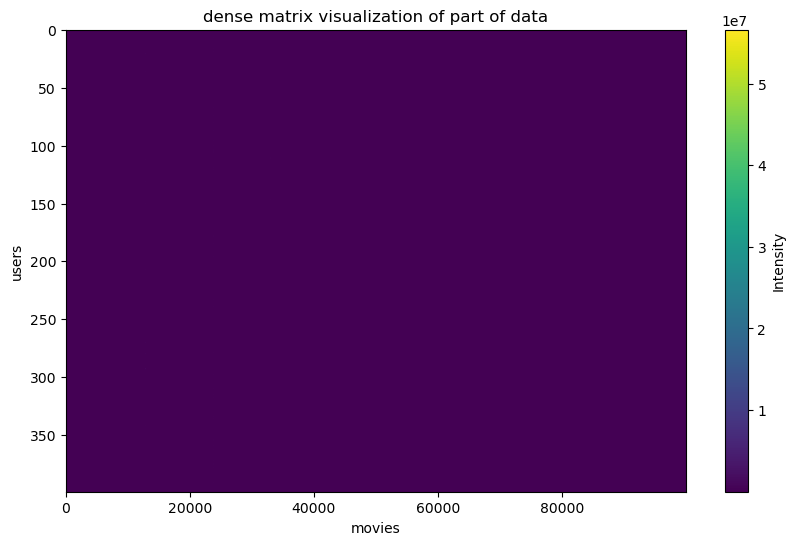

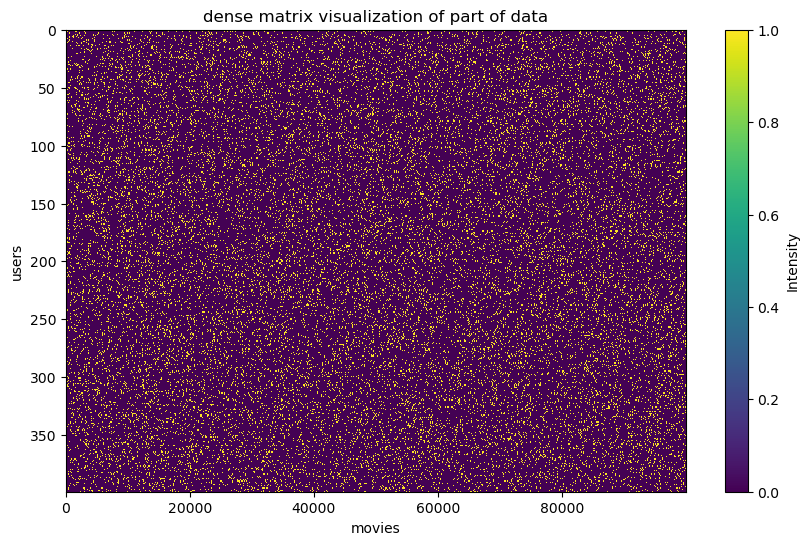

In [6]:
visualizeData(np.where(DENSE==0,np.nan,DENSE))
visualizeData(MASK)

In [7]:
import time
from scipy.sparse.linalg import svds
from scipy.linalg import norm
import numpy as np

In [8]:

def svt(data_matrix, step_size, tolerance, tau, max_iter, mask, max_rank=10):
    t = time.time()
    # Initialize k and a Y_0
    k = 1
    Y_0 = k_0_finder(tau, step_size, data_matrix*mask) * step_size * data_matrix*mask
    
    # Tracking variables
    rank_arr = []
    rel_error_s_arr = []

    # Iterative SVT
    Y = Y_0
    print(f'Y_0 maken duurde {time.time()-t} s')
    print('Starting up...')
    
    for k in range(1, max_iter + 1):
        # Compute top singular values/vectors using sparse SVD
        U, sigma, Vt = svd(Y,full_matrices=False)
        print(f'sigma = {sigma[:3]}')
        
        # Thresholding singular values
        sigma_thresh = np.maximum(sigma - tau, 0)
        rank = np.sum(sigma_thresh > 0)

        # Construct the low-rank approximation
        X = U[:, :rank] @ np.diag(sigma_thresh[:rank]) @ Vt[:rank, :]


        # Calculate relative error
        error_sampled_matrix = mask *(data_matrix - X)
        
        rel_insampling, rel_outsampling, rel_gen_err = allErrors(data_matrix, X,mask)
        r_err_stop = np.sqrt(rel_insampling/100)
        
        # Adjust step size for stability
        if r_err_stop < 1e-2:
            step_size *= 0.9
        
        # Update Y
        Y += step_size * error_sampled_matrix

        # Store metrics
        rank_arr.append(rank)
        rel_error_s_arr.append([rel_insampling, rel_outsampling, rel_gen_err])

        # Print iteration details
        print(f'Iter {k};')
        print(f'IS={rel_insampling}; OS={rel_outsampling}; GE={rel_gen_err}')
        print('Rank:', rank)
        print()

        # Check stopping conditions
        if rank > max_rank or r_err_stop < tolerance or suggested_stop(X, data_matrix, tolerance):
            break
    
    return X, rank_arr, k, rel_error_s_arr


In [9]:
DENSE.shape

(400, 100000)

In [12]:


# Parameters for SVT
step_size = 1.2
tolerance = 1e-4
tau = 800*(max(DENSE.shape))
max_iter = 500
max_rank = min(DENSE.shape)//10


# Run SVT
X, rank_arr, num_iters, rel_errors = svt(DENSE, step_size, tolerance, tau, max_iter,MASK, max_rank)
print("Final rank:", rank_arr[-1])
print("Number of iterations:", num_iters)


Y_0 maken duurde 3.650388717651367 s
Starting up...
sigma = [1.30185152e+08 1.02084344e+08 9.13584960e+07]
Iter 1;
IS=11.535022577288979; OS=79.98600429602955; GE=91.5210268733188
Rank: 3

sigma = [2.0918939e+08 1.7593510e+08 1.6263411e+08]
Iter 2;
IS=3.990335166914203; OS=77.47456110748857; GE=81.46489627440273
Rank: 6

sigma = [1.9797963e+08 1.6293136e+08 1.5362645e+08]
Iter 3;
IS=2.1559822601092793; OS=75.53890263415161; GE=77.69488489426082
Rank: 9

sigma = [2.0214886e+08 1.6534760e+08 1.5503182e+08]
Iter 4;
IS=1.7101689953328152; OS=73.8884585782928; GE=75.59862757362555
Rank: 10

sigma = [2.0421613e+08 1.6497491e+08 1.5573069e+08]
Iter 5;
IS=1.3359862247593433; OS=72.40413327664166; GE=73.74011950140093
Rank: 11

sigma = [2.0712875e+08 1.6518733e+08 1.5787182e+08]
Iter 6;
IS=1.0614168034887443; OS=71.24190105606525; GE=72.30331785955416
Rank: 12

sigma = [2.1021672e+08 1.6544845e+08 1.6079848e+08]
Iter 7;
IS=0.8429228980878762; OS=70.40308194378996; GE=71.24600484187789
Rank: 15


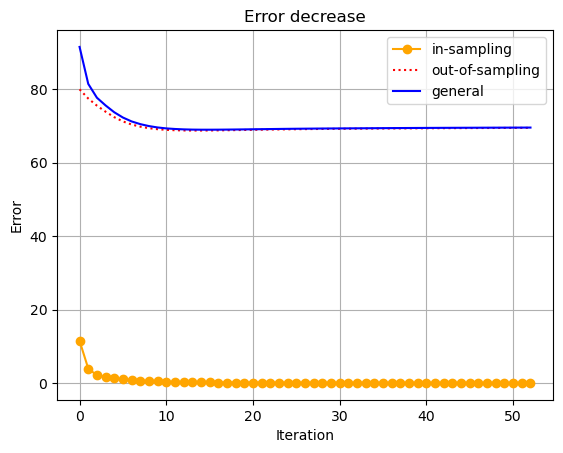

In [13]:
relErrorPlot(rel_errors)

In [16]:
rel_errors = np.array(rel_errors)

In [20]:
is_errs = rel_errors[:,0]
os_errs = rel_errors[:,1]
g_errs = rel_errors[:,2]

In [2]:
rank = np.array(rank_arr)

NameError: name 'np' is not defined

In [41]:
iters = np.linspace(1,53,53)

In [42]:
import pandas as pd

# Create a DataFrame
data = {
    "iterations": iters,
    "rank": rank,
    "insampling_error": is_errs,
    "outofsampling_error": os_errs,
    "general_error": g_errs
}
df = pd.DataFrame(data)

# Save to CSV
df.to_csv("SVT_tau800(max(n,m))_FTICRn400xm100000.csv", index=False)



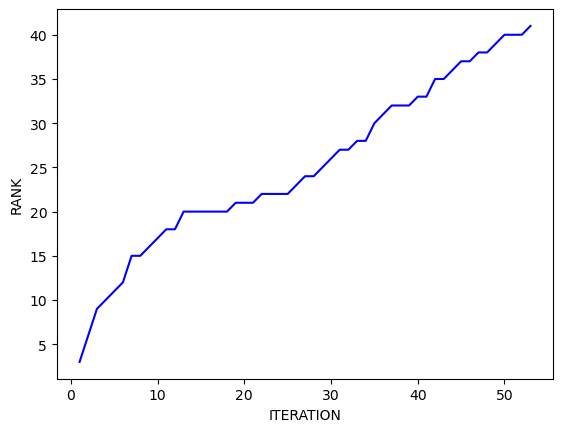

In [ ]:
import matplotlib.pyplot as plt

# Plot the values
plt.plot(iters, rank, linestyle='-', color='b', label='Values')

# Add labels and title
plt.xlabel('ITERATION')
plt.ylabel('RANK')

# Display the plot
plt.show()


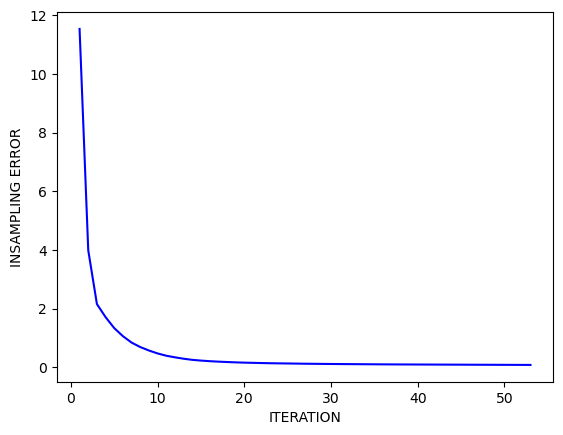

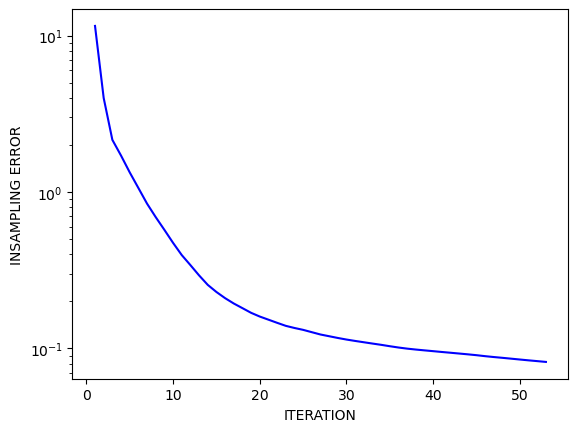

In [50]:
# Plot the values
plt.plot(iters, is_errs, linestyle='-', color='b', label='Values')

# Add labels and title
plt.xlabel('ITERATION')
plt.ylabel('INSAMPLING ERROR')
# plt.yscale('log')

# Display the plot
plt.show()

# Plot the values
plt.plot(iters, is_errs, linestyle='-', color='b', label='Values')

# Add labels and title
plt.xlabel('ITERATION')
plt.ylabel('INSAMPLING ERROR')
plt.yscale('log')

# Display the plot
plt.show()

In [3]:
import numpy as np

# Importing data from a CSV file
data = np.loadtxt('SVT_tau800(max(n,m))_FTICRn400xm100000.csv', delimiter=',', skiprows=1)


# "iterations": iters,
# "rank": rank,
# "insampling_error": is_errs,
# "outofsampling_error": os_errs,
# "general_error": g_errs
# Separate columns into individual NumPy arrays
iters = data[:, 0]
rank = data[:, 1]
is_errs = data[:, 2]
os_errs = data[:, 3]
g_errs = data[:, 4]



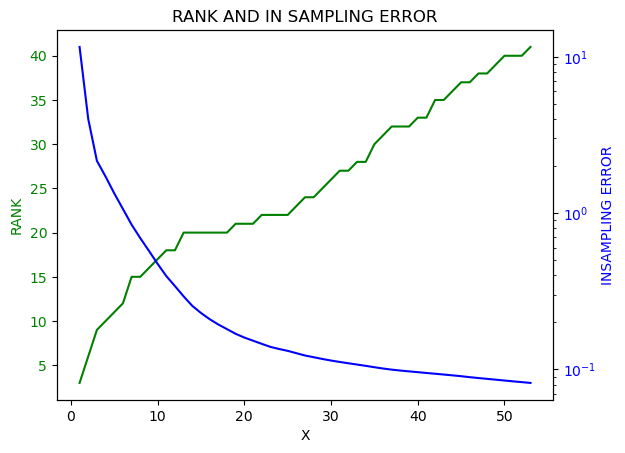

In [7]:
import matplotlib.pyplot as plt

# Example data
x = iters
y1 = rank  # First y-axis data
y2 = is_errs     # Second y-axis data

# Create the figure and axis
fig, ax1 = plt.subplots()

# Plot on the first y-axis
ax1.plot(x, y1, 'g-', label='RANK')  # Green line for y1
ax1.set_xlabel('X')
ax1.set_ylabel('RANK', color='g')
ax1.tick_params(axis='y', labelcolor='g')

# Create the second y-axis that shares the same x-axis
ax2 = ax1.twinx()

# Plot on the second y-axis
ax2.plot(x, y2, 'b-', label='INSAMPLING ERROR')  # Blue line for y2
ax2.set_ylabel('INSAMPLING ERROR', color='b')
ax2.tick_params(axis='y', labelcolor='b')
ax2.set_yscale('log')
# Title and show plot
plt.title('RANK AND IN SAMPLING ERROR')
plt.show()
